# 正弦信号发生


## 查表法构建正弦信号
事先存储好需要计算的正弦函数值，然后通过保持的方式输出，则得到离散的波形，最后使用低通滤波，使曲线更加光滑。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


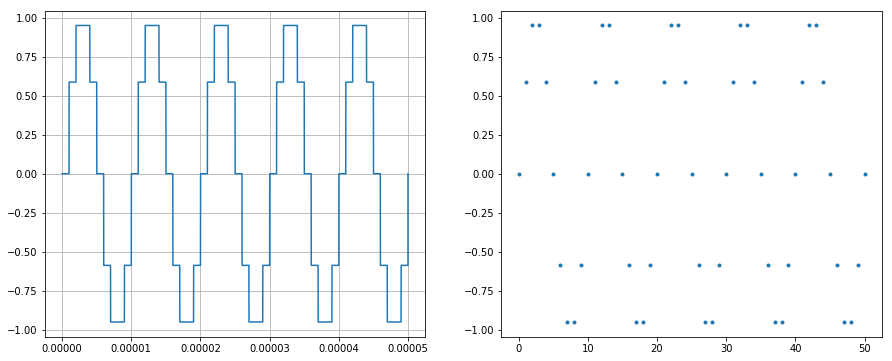

In [2]:
# 查表法生成正弦信号函数
def signal_sin(A, f, n, dt) :
    # A表示幅值，f表示频率，n表示需要填充的点数，dt表示仿真时的离散时间最小单位
    T = 1/f
    t = np.arange(0, 5*T + 2*dt, dt)    # 仿真10个周期时间
    
    
    delta_t = T/n                   # 表示信号的保持时间
    delta_n = delta_t / dt          # 信号保持的仿真间隔   
    signal = []                     # 初始化信号
    signal2 = []
    data = math.sin(2*math.pi*0/T)  # 初始填充值
    count = 0
    signal2.append(data)
    for i in t :
        if i >= (count + 1)*delta_t : # 判断是否到下一个时间平台
            count = (count + 1)
            data = math.sin(2*math.pi*(count%n)*delta_t/T) # 更改填充数值，直接调用系统函数，相当于查表
            signal2.append(data)
        signal.append(data)
        
    np_signal = np.array(signal)
    np_signal2 = np.array(signal2)
    return [t, np_signal, signal2]

# 测试
[t, sin_signal, signal2] = signal_sin(1, 100000, 10, 1e-9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(t, sin_signal)
ax1.grid()
ax2.plot(signal2,'.')


# CORDIC法生成正弦信号
CORDIC法是一种迭代法计算正弦信号的方法。这种方法将计算三角函数这种非线性函数，巧妙运用坐标变换的性质设计了一种迭代计算的方法，使得三角函数可以通过迭代的方式计算，并且可以很方便的控制精度。
## 基本原理
坐标变换的公式为：               
$$                          
\begin{equation}
x' = x \cdot cos\theta - y \cdot sin\theta \\
y' = x \cdot sin\theta + y \cdot cos\theta
\end{equation}
$$
其本质是矩阵的线性变换
$$
\begin{equation}
\left[\begin{matrix}x'\\y'\end{matrix}\right]
= \left[ \begin{matrix}
cos\theta & -sin\theta\\
sin\theta & cos\theta
\end{matrix} \right]
\left[\begin{matrix} x\\y \end{matrix}\right]
\end{equation}
$$
通过三角函数的万能公式，可以进一步使其化简：
\begin{equation}
con\theta = \frac{tan\theta}{\sqrt{1 + tan\theta^2}} \\
sin\theta = \frac{1}{\sqrt{1 + tan\theta^2}}
\end{equation}
带入之后，构成迭代公式则可以组成只有乘法和加法的迭代运算。

首先需要得到需要存储的数值

In [3]:
a = np.array([2**(-i) for i in range(11)])
phi = np.arctan(a) / math.pi * 180
# print(phi)

phi = np.round(phi,2)
k = np.cos(np.arctan(a))
print(phi)
print(k)

[ 45.    26.57  14.04   7.13   3.58   1.79   0.9    0.45   0.22   0.11
   0.06]
[ 0.70710678  0.89442719  0.9701425   0.99227788  0.99805258  0.99951208
  0.99987795  0.99996948  0.99999237  0.99999809  0.99999952]


In [4]:
# CORDIC正弦函数运算方法
def cordic_sin(theta, error, debug=0) :
    # 先处理数据，只能计算0～90的
    tmp = round(theta / 360 - 0.5) 
    
    theta = theta - tmp * 360
    sign = 1
    if theta > 90 and theta <= 180 :
        theta = abs(theta - 180)
        sign = 1
    elif theta > 180 and theta <= 270 :
        theta = theta - 180
        sign = -1
    elif theta > 270 and theta <= 360 :
        theta = abs(theta - 360)
        sign = -1
        
    x = 1
    y = 0
    theta_real = 0
    index = 0
    d = 1
    if debug :
        print('%d %lf %d %lf %lf'%(index, theta_real,d,x,y))
    while True:
        if index == 11 :
            break
        if abs(theta_real-theta) <= error * theta :
            break  # 达到误差就跳出
        if theta_real < theta : # 决定该次的符号
            d = 1
        else :
            d = -1
         
        # 执行迭代步骤
        tmpx = x
        tmpy = y
        x = (tmpx - tmpy*d*2**(-index))*k[index]
        y = (tmpy + tmpx*d*2**(-index))*k[index]
        theta_real = theta_real + d*phi[index]
        index = index + 1
        if debug :
            print('%d %lf %d %lf %lf'%(index, theta_real,d,x,y))
    return sign * y
th = 500
print('result = %lf, real = %lf'%(cordic_sin(38, 0.01, debug=1),math.sin(38/180*math.pi)))

0 0.000000 1 1.000000 0.000000
1 45.000000 1 0.707107 0.707107
2 18.430000 -1 0.948683 0.316228
3 32.470000 1 0.843661 0.536875
4 39.600000 1 0.770555 0.637373
5 36.020000 -1 0.808813 0.588066
6 37.810000 1 0.790050 0.613042
result = 0.613042, real = 0.615661


In [5]:
# CORDIC正弦函数运算方法
def cordic_arcsin(sin_num, error, debug=0) :
        
    x = 1
    y = 0
    theta_real = 0
    index = 0
    d = 1
    if debug :
        print('%d %lf %d %lf %lf'%(index, theta_real,d,x,y))
    while True:
        if index == 11 :
            break
        if abs(y-sin_num) <= error * sin_num :
            break  # 达到误差就跳出
        if y < sin_num : # 决定该次的符号
            d = 1
        else :
            d = -1
         
        # 执行迭代步骤
        tmpx = x
        tmpy = y
        x = (tmpx - tmpy*d*2**(-index))*k[index]
        y = (tmpy + tmpx*d*2**(-index))*k[index]
        theta_real = theta_real + d*phi[index]
        index = index + 1
        if debug :
            print('%d %lf %d %lf %lf'%(index, theta_real,d,x,y))
    return theta_real
th = 500
print('result = %lf, real = %lf'%(cordic_arcsin(0.4, 0.01, debug=1),math.asin(0.4)*180/math.pi))

0 0.000000 1 1.000000 0.000000
1 45.000000 1 0.707107 0.707107
2 18.430000 -1 0.948683 0.316228
3 32.470000 1 0.843661 0.536875
4 25.340000 -1 0.903738 0.428086
5 21.760000 -1 0.928681 0.370879
6 23.550000 1 0.916644 0.399705
result = 23.550000, real = 23.578178


使用cordic方法产生正弦信号

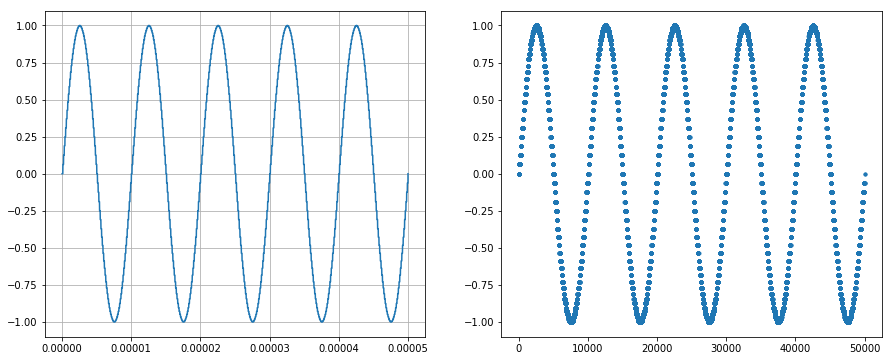

In [6]:
# 查表法生成正弦信号函数
def signal_sin_cordic(A, f, n, dt) :
    # A表示幅值，f表示频率，n表示需要填充的点数，dt表示仿真时的离散时间最小单位
    T = 1/f
    t = np.arange(0, 5*T + 2*dt, dt)    # 仿真10个周期时间
    
    
    delta_t = T/n                   # 表示信号的保持时间
    delta_n = delta_t / dt          # 信号保持的仿真间隔   
    signal = []                     # 初始化信号
    signal2 = []
    data = cordic_sin(0,0.01)  # 初始填充值
    count = 0
    signal2.append(data)
    for i in t :
        if i >= (count + 1)*delta_t : # 判断是否到下一个时间平台
            count = (count + 1)
            tmp_theta = 360*(count%n)*delta_t/T
            data = cordic_sin(tmp_theta, 0.01) # 更改填充数值，直接调用系统函数，相当于查表
            signal2.append(data)
        signal.append(data)
        
    np_signal = np.array(signal)
    np_signal2 = np.array(signal2)
    return [t, np_signal, signal2]

# 测试
[t, sin_signal, signal2] = signal_sin_cordic(1, 100000, 100, 1e-9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(t, sin_signal)
ax1.grid()
ax2.plot(sin_signal,'.')


对上述两算法进行比较

In [7]:
%%time
[t, sin_signal, signal2] = signal_sin(1, 100000, 1000, 1e-9)

CPU times: user 28.2 ms, sys: 2.69 ms, total: 30.9 ms
Wall time: 38.6 ms


In [8]:
%%time
[t, sin_signal, signal2] = signal_sin_cordic(1, 100000, 1000, 1e-9)

CPU times: user 136 ms, sys: 7.09 ms, total: 143 ms
Wall time: 213 ms


可以发现，还是查表算法相对快一些，但是只需要优化，这种cordic算法的性能是十分可观的，而且占用存储空间极小。

## 作业1
产生频率为100kHz的信号，并分别使用10，20，40，100，400，800，2000个点并给予FFT显示

In [9]:
#构建一个测试函数, 查表法的测试
def test_func(n) :
    # 查表法
    [t, sin_signal, signal2] = signal_sin(1, 100000, n, 1e-9)
    fft_signal = np.fft.fft(signal2)/len(signal2)
    fft_signal = np.fft.fftshift(fft_signal)
    
    freq = np.arange(-1,1,2/len(signal2))
    freq = np.fft.fftfreq(len(fft_signal), 1./100000/n)
    freq.sort()
    idx = np.array([i for i in range(len(freq)) if freq[i] > -300000 and freq[i] < 300000])
#     print(freq)
    start = min(idx)
    end = max(idx)
#     print(start,end)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    ax1.plot(signal2,'.')
    ax1.set_title('sin signal n = %d'%n)
    ax1.set_xlabel('time')
    # ax1.title(siginal)
#     ax2.stem(freq[0:len(fft_signal)], abs(fft_signal))
    ax2.stem(freq[start:end+1], abs(fft_signal[start:end+1]))
    ax2.set_title('signal fft')
    ax2.set_xlabel('w/Hz')

### 查表法测试

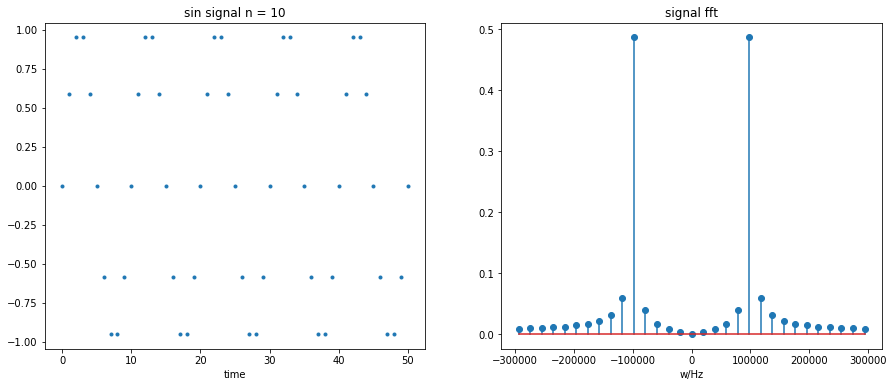

In [10]:
test_func(10)

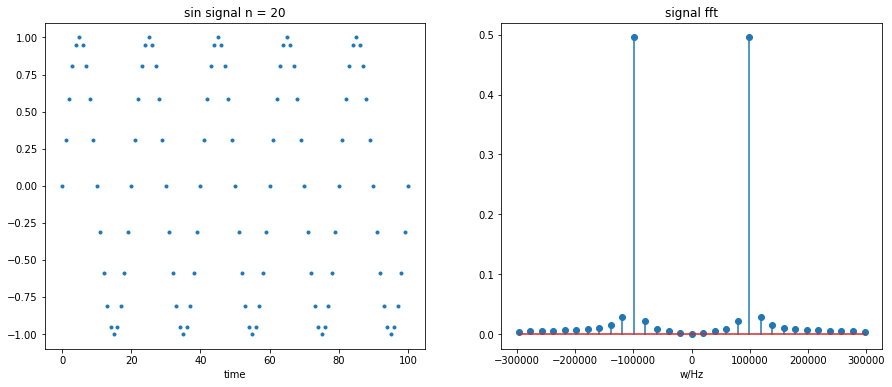

In [11]:
test_func(20)

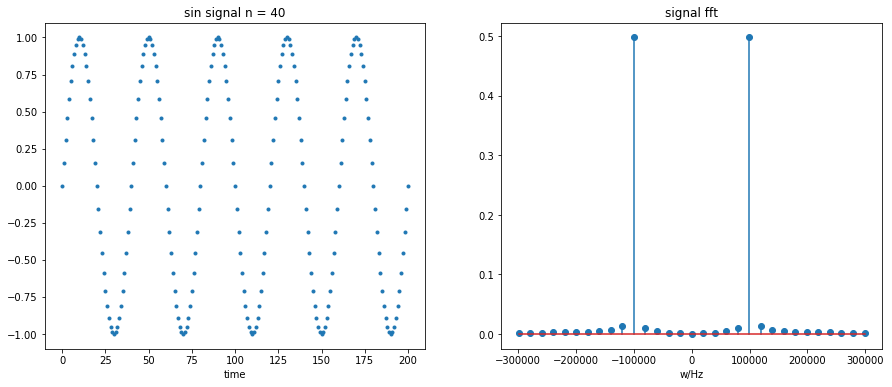

In [12]:
test_func(40)

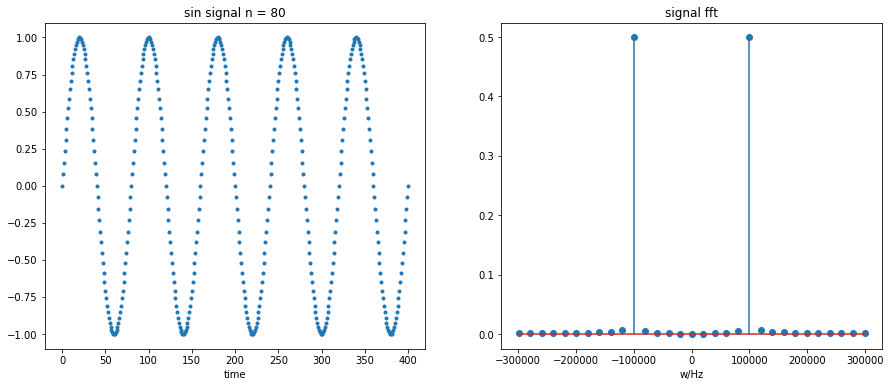

In [13]:
test_func(80)

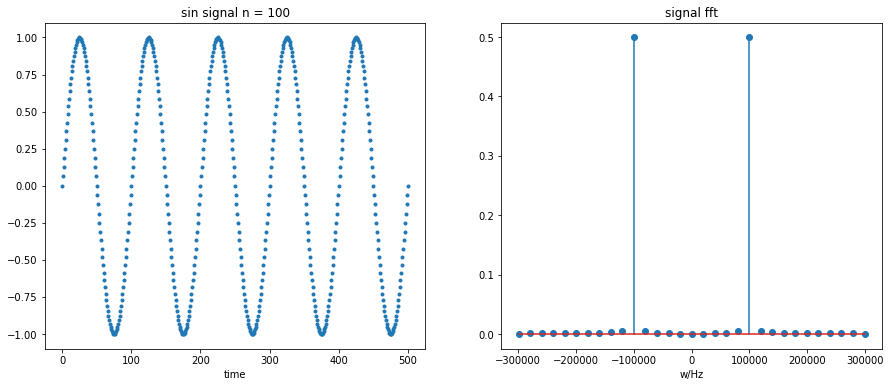

In [14]:
test_func(100)

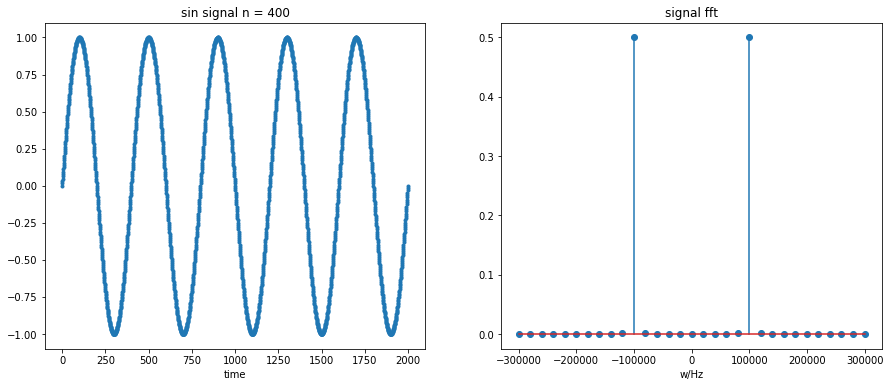

In [15]:
test_func(400)

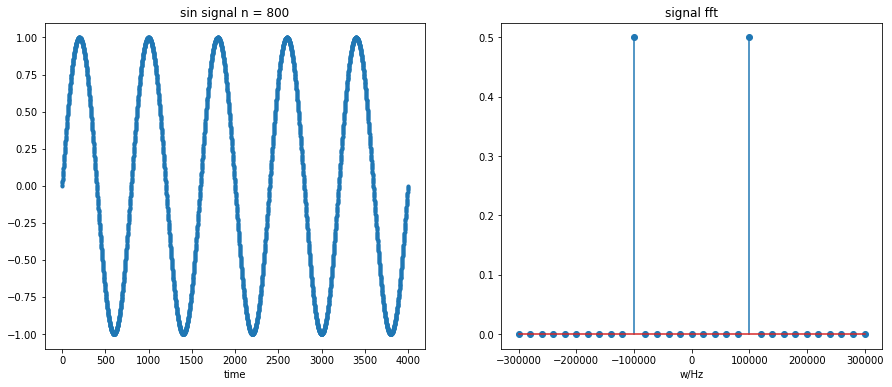

In [16]:
test_func(800)

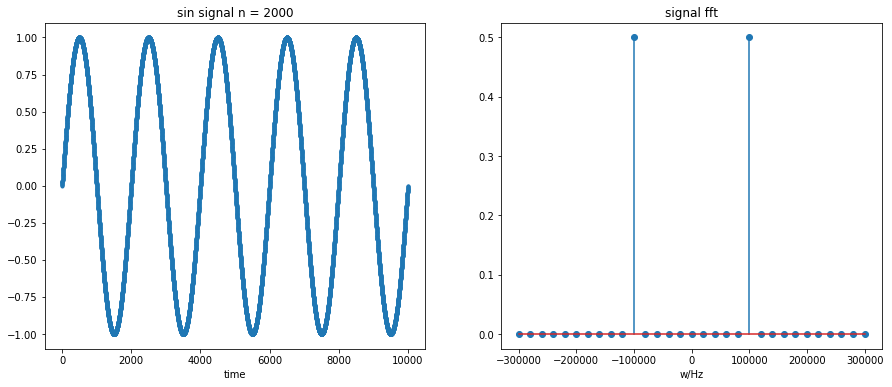

In [17]:
test_func(2000)

In [18]:
#构建一个测试函数, 查表法的测试
def test_func2(n) :
    # 查表法
    [t, sin_signal, signal2] = signal_sin_cordic(1, 100000, n, 1e-9)
    fft_signal = np.fft.fft(signal2)/len(signal2)
    fft_signal = np.fft.fftshift(fft_signal)
    
    freq = np.arange(-1,1,2/len(signal2))
    freq = np.fft.fftfreq(len(fft_signal), 1./100000/n)
    freq.sort()
    idx = np.array([i for i in range(len(freq)) if freq[i] > -300000 and freq[i] < 300000])
#     print(freq)
    start = min(idx)
    end = max(idx)
#     print(start,end)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    ax1.plot(signal2,'.')
    ax1.set_title('sin signal n = %d'%n)
    ax1.set_xlabel('time')
    # ax1.title(siginal)
#     ax2.stem(freq[0:len(fft_signal)], abs(fft_signal))
    ax2.stem(freq[start:end+1], abs(fft_signal[start:end+1]))
    ax2.set_title('signal fft')
    ax2.set_xlabel('w/Hz')
    

### cordic法测试

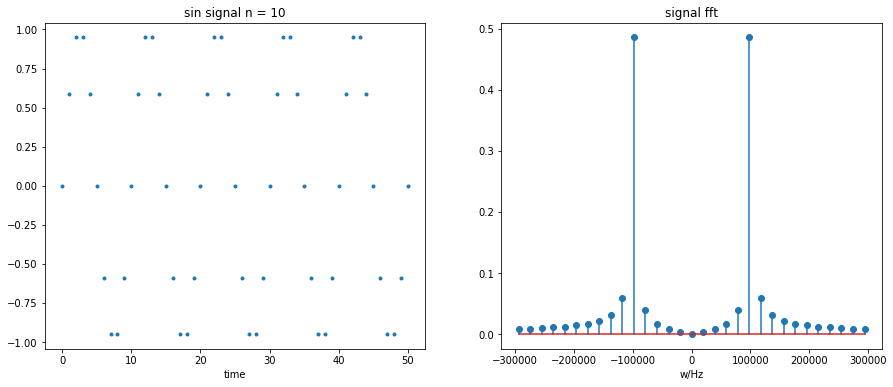

In [19]:
test_func2(10)

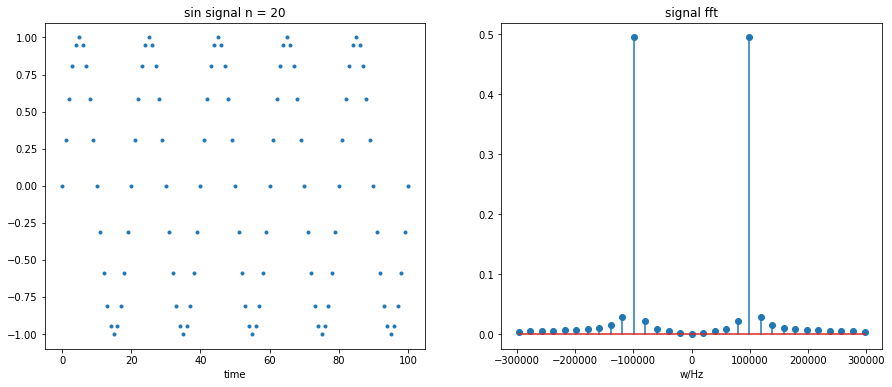

In [20]:
test_func2(20)

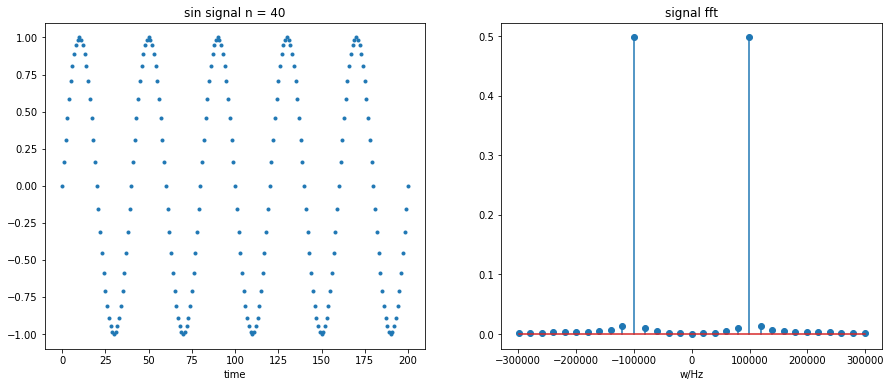

In [21]:
test_func2(40)

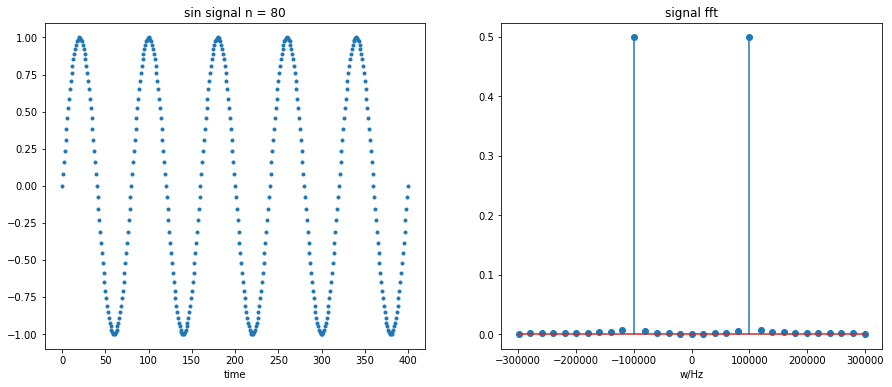

In [22]:
test_func2(80)

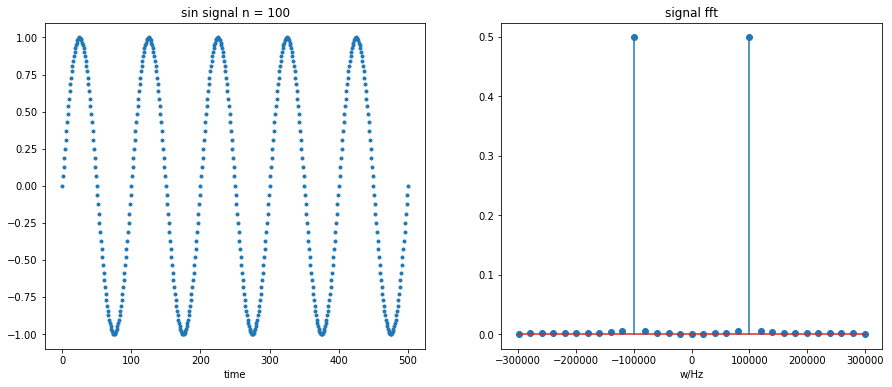

In [23]:
test_func2(100)

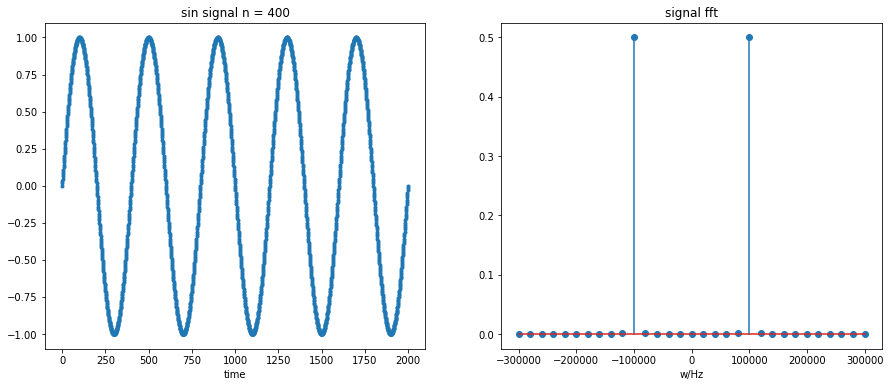

In [24]:
test_func2(400)

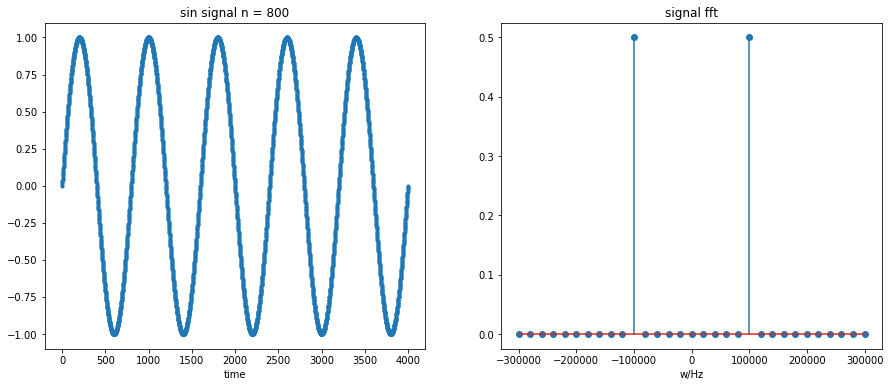

In [25]:
test_func2(800)

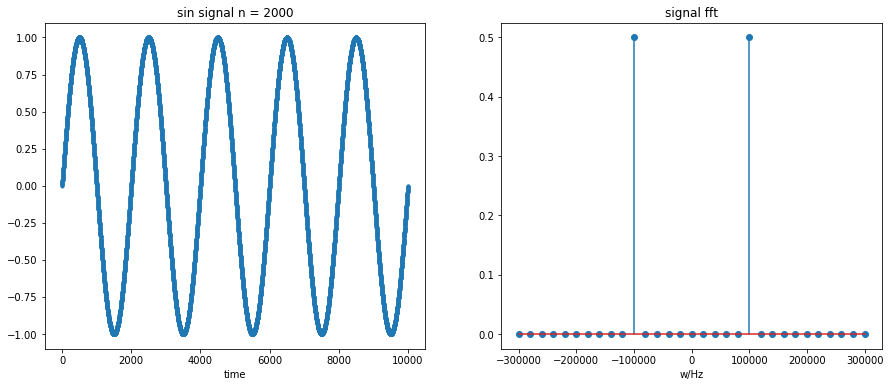

In [26]:
test_func2(2000)

### 实验结论
通过上述图示可以看出，当一个周期内取的点数逐渐增多，信号保持产生的台阶越来越少，其信号本身也与实际正弦曲线更加接近，但是为了能够产生的越来越接近于真实的正弦信号，需要极高的时钟频率，而这在实际应用中是不可能的，则应当对性能进行取舍。
从频谱图可以直观的看出，当取样点数越多，其频谱也越接近理想频谱曲线。